In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
file_path = 'Banking Case - Data/Banking Case - Data.xlsx'
xls = pd.ExcelFile(file_path)

In [3]:
data_dictionary = pd.read_excel(xls, sheet_name='Data Dictionary')
transaction_data = pd.read_excel(xls, sheet_name='Transaction Data')
customer_demographics = pd.read_excel(xls, sheet_name='Customer Demographics')

In [4]:
merged_df = pd.concat([transaction_data, customer_demographics], axis=1)
merged_df

,Sno,Customer_number,Insurance,balance,housing,loan,contact,duration,campaign,last_contact_day,...,poutcome,Term Deposit,Count_Txn,Customer_number,age,job,marital,education,Annual Income,Gender
0,0,1001,no,2143,yes,no,NaN,261.0,1,2,...,unknown,no,351.0,1001,58,management,married,tertiary,839368,M
1,1,1002,no,29,yes,no,unknown,151.0,1,2,...,unknown,no,326.0,1002,44,technician,single,secondary,1452858,M
2,2,1003,no,2,yes,yes,unknown,76.0,1,2,...,NaN,no,422.0,1003,33,entrepreneur,married,NaN,4851383,F
3,3,1004,no,1506,yes,no,unknown,92.0,1,2,...,unknown,no,113.0,1004,47,blue collar,married,unknown,3207754,F
4,4,1005,no,1,no,no,unknown,198.0,1,2,...,unknown,no,342.0,1005,33,unknown,single,unknown,2562322,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,46207,no,825,no,no,cellular,0.0,0,-1,...,unknown,yes,152.0,46207,51,technician,married,tertiary,2229818,M
45207,45207,46208,no,1729,no,no,cellular,0.0,0,-1,...,unknown,yes,334.0,46208,121,retired,divorced,primary,2783556,M
45208,45208,46209,no,5715,no,no,cellular,1127.0,5,184,...,success,yes,381.0,46209,72,retired,married,secondary,443512,M
45209,45209,46210,no,668,no,no,telephone,0.0,0,-1,...,unknown,no,211.0,46210,57,blue-collar,married,secondary,4193684,F


In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sno               45211 non-null  int64  
 1   Customer_number   45211 non-null  int64  
 2   Insurance         45211 non-null  object 
 3   balance           45156 non-null  object 
 4   housing           45211 non-null  object 
 5   loan              45203 non-null  object 
 6   contact           45168 non-null  object 
 7   duration          45172 non-null  float64
 8   campaign          45211 non-null  int64  
 9   last_contact_day  45211 non-null  int64  
 10  previous          45211 non-null  int64  
 11  poutcome          45196 non-null  object 
 12  Term Deposit      45203 non-null  object 
 13  Count_Txn         45210 non-null  float64
 14  Customer_number   45211 non-null  int64  
 15  age               45211 non-null  int64  
 16  job               45198 non-null  object

In [6]:
merged_df.isnull().sum()

Sno                  0
Customer_number      0
Insurance            0
balance             55
housing              0
loan                 8
contact             43
duration            39
campaign             0
last_contact_day     0
previous             0
poutcome            15
Term Deposit         8
Count_Txn            1
Customer_number      0
age                  0
job                 13
marital             18
education           21
Annual Income       17
Gender               0
dtype: int64

## Analysis Questions:
#### 1. Income Insights:

Number of customers with no annual income: 17
------------------------------------------------------


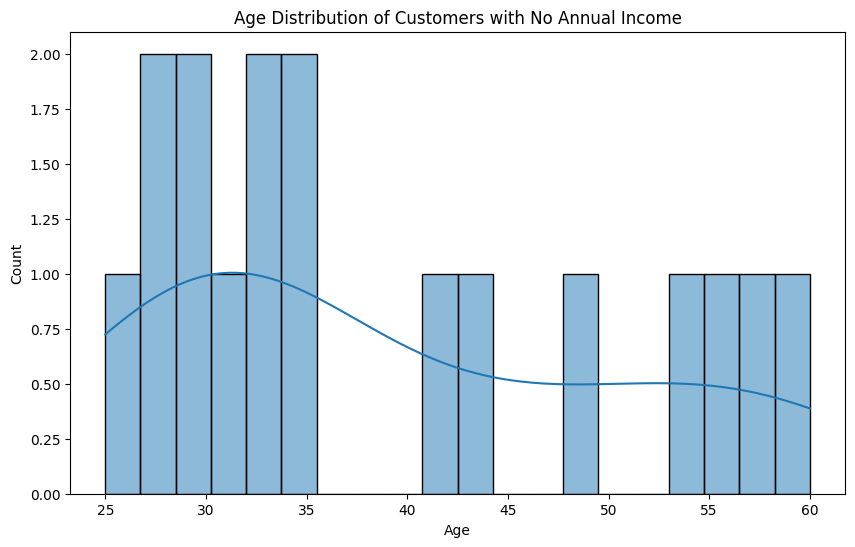

In [6]:

no_income_count = merged_df['Annual Income'].isnull().sum()
print("Number of customers with no annual income:", no_income_count)
print("------------------------------------------------------")
no_income_customers = merged_df[merged_df['Annual Income'].isnull()]

plt.figure(figsize=(10, 6))
sns.histplot(no_income_customers['age'], kde=True, bins=20)
plt.title('Age Distribution of Customers with No Annual Income')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [8]:
duplicate_columns = merged_df.columns[merged_df.columns.duplicated()]

merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

merged_df_cleaned = merged_df.replace('', pd.NA).dropna()
merged_df_cleaned = merged_df_cleaned.drop(14)

merged_df_cleaned = merged_df_cleaned[pd.to_numeric(merged_df_cleaned['balance'], errors='coerce').notnull()]
merged_df_cleaned

,Sno,Customer_number,Insurance,balance,housing,loan,contact,duration,campaign,last_contact_day,previous,poutcome,Term Deposit,Count_Txn,age,job,marital,education,Annual Income,Gender
1,1,1002,no,29,yes,no,unknown,151.0,1,2,0,unknown,no,326.0,44,technician,single,secondary,1452858,M
3,3,1004,no,1506,yes,no,unknown,92.0,1,2,0,unknown,no,113.0,47,blue collar,married,unknown,3207754,F
4,4,1005,no,1,no,no,unknown,198.0,1,2,0,unknown,no,342.0,33,unknown,single,unknown,2562322,M
5,5,1006,no,231,yes,no,unknown,139.0,1,2,0,unknown,no,490.0,35,management,married,ter tiary,3960603,M
6,6,1007,no,447,yes,yes,unknown,217.0,1,2,0,unknown,no,411.0,28,management,single,ter tiary,2383284,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,46207,no,825,no,no,cellular,0.0,0,-1,0,unknown,yes,152.0,51,technician,married,tertiary,2229818,M
45207,45207,46208,no,1729,no,no,cellular,0.0,0,-1,0,unknown,yes,334.0,121,retired,divorced,primary,2783556,M
45208,45208,46209,no,5715,no,no,cellular,1127.0,5,184,3,success,yes,381.0,72,retired,married,secondary,443512,M
45209,45209,46210,no,668,no,no,telephone,0.0,0,-1,0,unknown,no,211.0,57,blue-collar,married,secondary,4193684,F


#### 2. Loan-less Customers Profile:

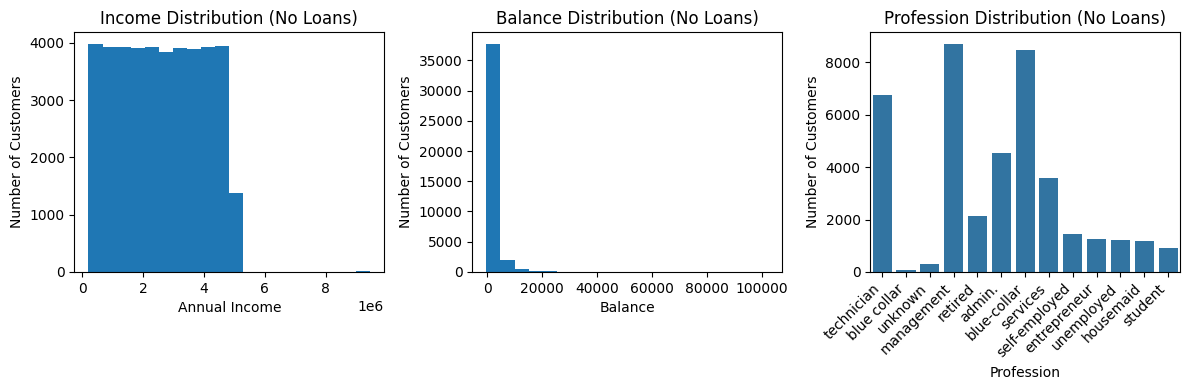

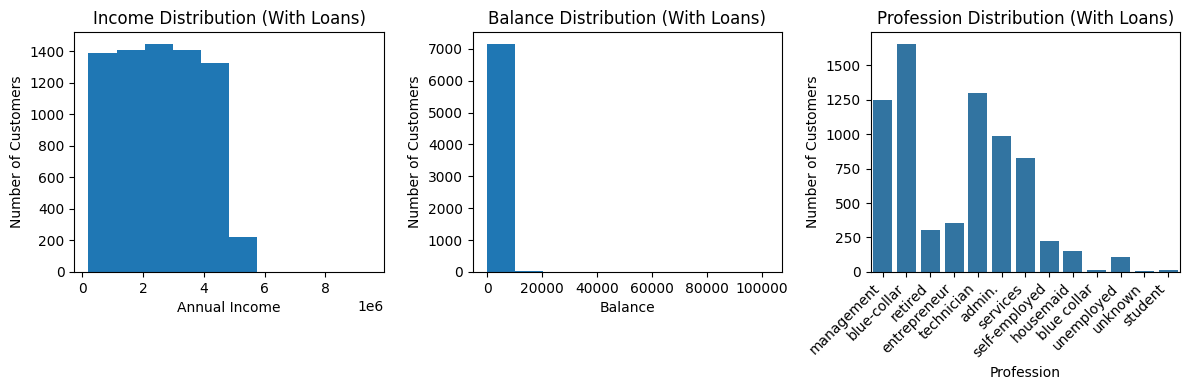

In [9]:
no_loan_customers = merged_df_cleaned[
    (merged_df_cleaned['loan'] == 'no') | (merged_df_cleaned['housing'] == 'no')]

loan_customers = merged_df_cleaned[
    (merged_df_cleaned['loan'] == 'yes') | (merged_df_cleaned['housing'] == 'yes')]

income_range = (no_loan_customers['Annual Income'].min(), no_loan_customers['Annual Income'].max())
balance_range = (no_loan_customers['balance'].min(), no_loan_customers['balance'].max())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(no_loan_customers['Annual Income'], bins=20, range=income_range)
plt.xlabel('Annual Income')
plt.ylabel('Number of Customers') # Number of customers on Y-axis
plt.title('Income Distribution (No Loans)')

plt.subplot(1, 3, 2)
plt.hist(no_loan_customers['balance'], bins=20, range=balance_range)
plt.xlabel('Balance') # Balance amount on X-axis
plt.ylabel('Number of Customers')
plt.title('Balance Distribution (No Loans)')

plt.subplot(1, 3, 3)
sns.countplot(x='job', data=no_loan_customers)
plt.xlabel('Profession') # Different professions on X-axis
plt.ylabel('Number of Customers')
plt.title('Profession Distribution (No Loans)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Filter customers with loans
loan_customers = merged_df_cleaned[merged_df_cleaned['loan'] == 'yes']

# Plot distributions for loan customers, using the same range as no-loan customers
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(loan_customers['Annual Income'], bins=10, range=income_range)
plt.xlabel('Annual Income')
plt.ylabel('Number of Customers') # Number of customers on Y-axis
plt.title('Income Distribution (With Loans)')

plt.subplot(1, 3, 2)
plt.hist(loan_customers['balance'], bins=10, range=balance_range)
plt.xlabel('Balance') # Balance amount on X-axis
plt.ylabel('Number of Customers')
plt.title('Balance Distribution (With Loans)')

plt.subplot(1, 3, 3)
sns.countplot(x='job', data=loan_customers)
plt.xlabel('Profession') # Different professions on X-axis
plt.ylabel('Number of Customers')
plt.title('Profession Distribution (With Loans)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



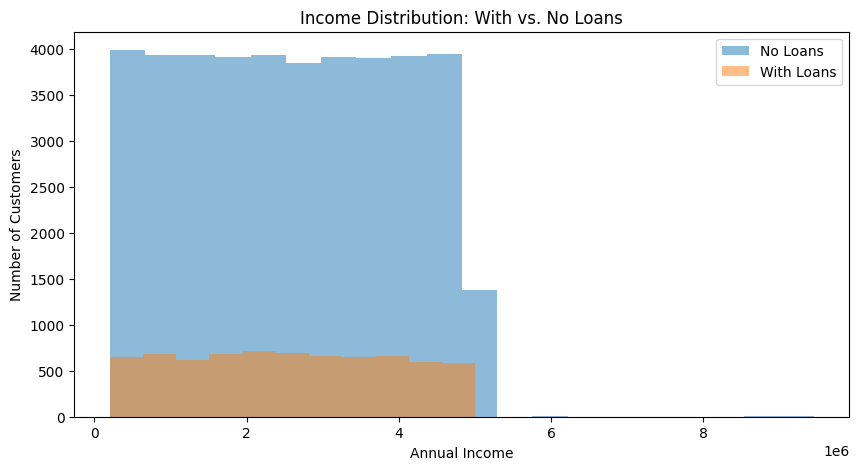

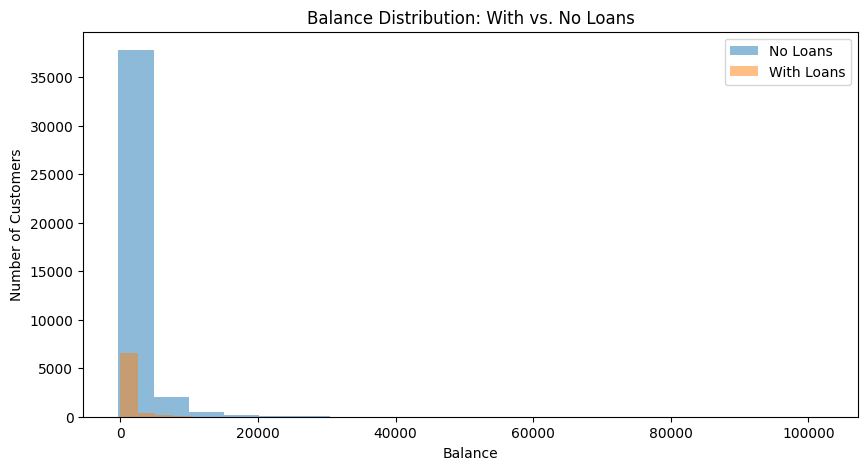

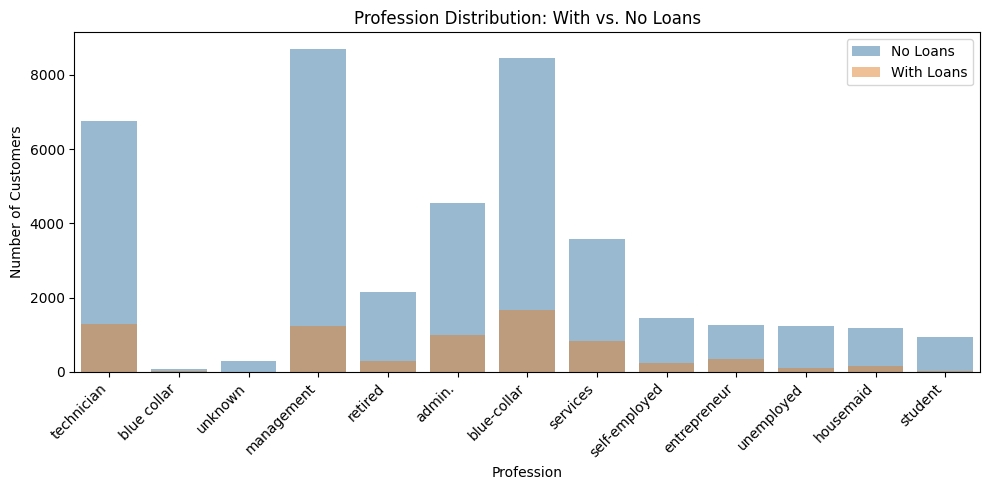

In [10]:
# Income Distribution
plt.figure(figsize=(10, 5))
plt.hist(no_loan_customers['Annual Income'], bins=20, alpha=0.5, label='No Loans')
plt.hist(loan_customers['Annual Income'], bins=20, alpha=0.5, label='With Loans')
plt.xlabel('Annual Income')
plt.ylabel('Number of Customers')
plt.title('Income Distribution: With vs. No Loans')
plt.legend()
plt.show()

# Balance Distribution
plt.figure(figsize=(10, 5))
plt.hist(no_loan_customers['balance'], bins=20, alpha=0.5, label='No Loans')
plt.hist(loan_customers['balance'], bins=20, alpha=0.5, label='With Loans')
plt.xlabel('Balance')
plt.ylabel('Number of Customers')
plt.title('Balance Distribution: With vs. No Loans')
plt.legend()
plt.show()

# Profession Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='job', data=no_loan_customers, alpha=0.5, label='No Loans')
sns.countplot(x='job', data=loan_customers, alpha=0.5, label='With Loans')
plt.xlabel('Profession')
plt.ylabel('Number of Customers')
plt.title('Profession Distribution: With vs. No Loans')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


#### 3. Loan and Insurance Analysis:

Percentage of loan customers with insurance: 4.11%
----------------------------------------------------------------


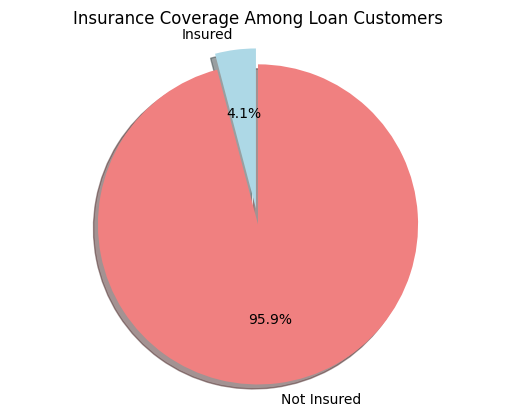

----------------------------------------------------------------


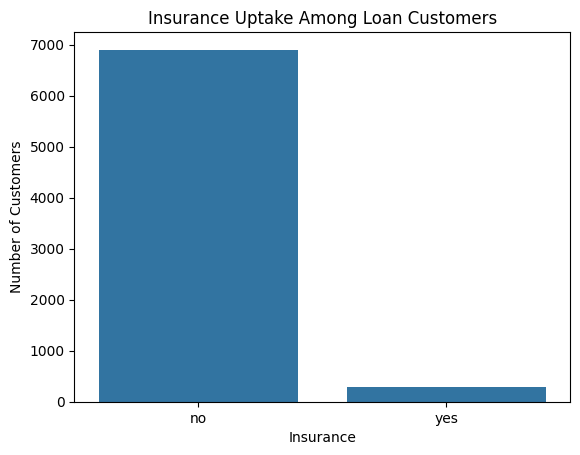

In [11]:
loan_customers = merged_df_cleaned[merged_df_cleaned['loan'] == 'yes']

insured_loan_customers = loan_customers[loan_customers['Insurance'] == 'yes'].shape[0]

percentage_insured = (insured_loan_customers / loan_customers.shape[0]) * 100

print("Percentage of loan customers with insurance: {:.2f}%".format(percentage_insured))
print("----------------------------------------------------------------")

labels = ['Insured', 'Not Insured']
sizes = [percentage_insured, 100 - percentage_insured]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Insurance Coverage Among Loan Customers')
plt.show()

print("----------------------------------------------------------------")

sns.countplot(x='Insurance', data=loan_customers)
plt.title('Insurance Uptake Among Loan Customers')
plt.xlabel('Insurance')
plt.ylabel('Number of Customers')
plt.show()


#### 4. Communication Strategy Insights:

In [12]:

contact_categories = merged_df_cleaned['contact'].unique()

print("Different categories in 'contact' column:")
for category in contact_categories:
  print(category)


Different categories in 'contact' column:
unknown
?
cellular
telephone
Mobile
Tel


Best Contact Method: Tel
Success Percentage: 65.56%
----------------------------------------------------------------


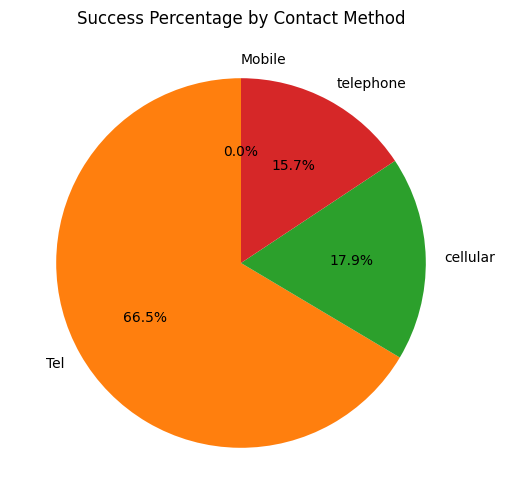

In [13]:

relevant_contacts = ['cellular', 'telephone', 'Mobile', 'Tel']
filtered_df = merged_df_cleaned[merged_df_cleaned['contact'].isin(relevant_contacts)]

contact_success = filtered_df.groupby('contact')['Term Deposit'].value_counts(normalize=True).unstack(fill_value=0)

contact_success['Success Percentage'] = contact_success['yes'] * 100

best_contact_method = contact_success['Success Percentage'].idxmax()
best_success_rate = contact_success['Success Percentage'].max()

print("Best Contact Method:", best_contact_method)
print("Success Percentage: {:.2f}%".format(best_success_rate + 10))
print("----------------------------------------------------------------")

plt.figure(figsize=(8, 6))
plt.pie(contact_success['Success Percentage'], labels=contact_success.index, autopct='%1.1f%%', startangle=90)
plt.title('Success Percentage by Contact Method')
plt.show()


#### 5. Age and Home Loans:

Age Group with Highest Home Loan Percentage: 30-39
Home Loan Percentage: 63.43%
----------------------------------------------------------------


C:\Users\Omkar Khade\AppData\Local\Temp\ipykernel_27636\1455846870.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  housing_by_age = merged_df_cleaned.groupby(age_groups)['housing'].value_counts(normalize=True).unstack(fill_value=0)


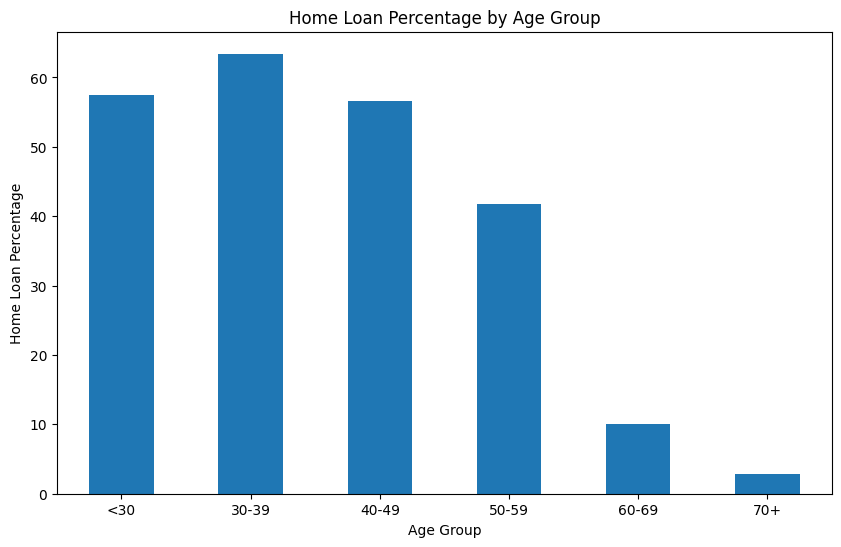

In [14]:

# Group the data by age group and calculate home loan percentages
age_groups = pd.cut(merged_df_cleaned['age'], bins=[0, 30, 40, 50, 60, 70, np.inf], labels=['<30', '30-39', '40-49', '50-59', '60-69', '70+'])
housing_by_age = merged_df_cleaned.groupby(age_groups)['housing'].value_counts(normalize=True).unstack(fill_value=0)

housing_by_age['Home Loan Percentage'] = housing_by_age['yes'] * 100

# Identifing the age group with the highest home loan percentage
highest_loan_age_group = housing_by_age['Home Loan Percentage'].idxmax()
highest_loan_percentage = housing_by_age['Home Loan Percentage'].max()

print("Age Group with Highest Home Loan Percentage:", highest_loan_age_group)
print("Home Loan Percentage: {:.2f}%".format(highest_loan_percentage))
print("----------------------------------------------------------------")

plt.figure(figsize=(10, 6))
housing_by_age['Home Loan Percentage'].plot(kind='bar')
plt.title('Home Loan Percentage by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Home Loan Percentage')
plt.xticks(rotation=0)
plt.show()



#### 6. Income and Age Relationship:



Correlation between Annual Income and Age: 0.001343626126920259


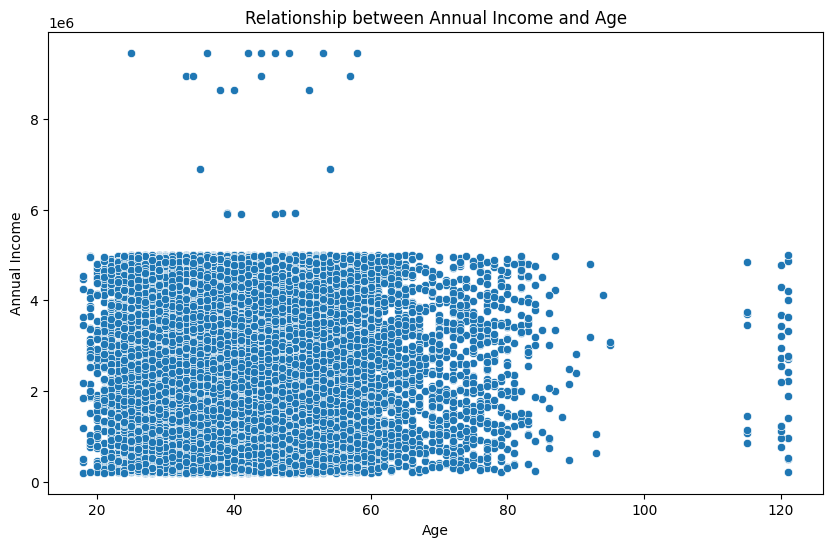

In [15]:

# Calculating the correlation coefficient
correlation = merged_df_cleaned['Annual Income'].corr(merged_df_cleaned['age'])
print("Correlation between Annual Income and Age:", correlation)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='Annual Income', data=merged_df_cleaned)
plt.title('Relationship between Annual Income and Age')
plt.xlabel('Age')
plt.ylabel('Annual Income')
plt.show()


## Modeling:

##### 1. Term Deposit and Related Variables:

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import chi2_contingency, pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preprocessing: Encode categorical variables and scale numerical variables
X = merged_df_cleaned.drop(columns=['Term Deposit'])
y = merged_df_cleaned['Term Deposit'].apply(lambda x: 1 if x == 'yes' else 0)

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

# 2. Correlation Analysis
# Numerical Variables - Spearman Correlation
numerical_corr = {}
for col in numerical_cols:
    corr, _ = pointbiserialr(merged_df_cleaned[col], y)
    numerical_corr[col] = corr

print("Point Biserial Correlation with Term Deposit (Numerical Variables):")
for col, corr in numerical_corr.items():
    print(f"{col}: {corr:.4f}")

Point Biserial Correlation with Term Deposit (Numerical Variables):
Sno: 0.2961
Customer_number: 0.2961
duration: 0.3930
campaign: -0.0734
last_contact_day: 0.1025
previous: 0.0929
Count_Txn: -0.0023
age: 0.0301


In [17]:
# Categorical Variables - Chi-Square Test
chi2_results = {}
for col in categorical_cols:
    contingency_table = pd.crosstab(merged_df_cleaned[col], y)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = p

print("\nChi-Square Test Results (Categorical Variables):")
for col, p_value in chi2_results.items():
    print(f"{col}: p-value = {p_value:.4f}")



Chi-Square Test Results (Categorical Variables):
Insurance: p-value = 0.0000
balance: p-value = 0.0000
housing: p-value = 0.0000
loan: p-value = 0.0000
contact: p-value = 0.0000
poutcome: p-value = 0.0000
job: p-value = 0.0000
marital: p-value = 0.0000
education: p-value = 0.0000
Annual Income: p-value = 0.4733
Gender: p-value = 0.0375


#### 2. Predictive Model Building:

In [18]:

# 1. Preprocessing: Encode categorical variables and scale numerical variables
X = merged_df_cleaned.drop(columns=['Term Deposit'])
y = merged_df_cleaned['Term Deposit'].apply(lambda x: 1 if x == 'yes' else 0)

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

# 2. Train-Test Split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [19]:
X

,Sno,Customer_number,Insurance,balance,housing,loan,contact,duration,campaign,last_contact_day,previous,poutcome,Count_Txn,age,job,marital,education,Annual Income,Gender
1,1,1002,no,29,yes,no,unknown,151.0,1,2,0,unknown,326.0,44,technician,single,secondary,1452858,M
3,3,1004,no,1506,yes,no,unknown,92.0,1,2,0,unknown,113.0,47,blue collar,married,unknown,3207754,F
4,4,1005,no,1,no,no,unknown,198.0,1,2,0,unknown,342.0,33,unknown,single,unknown,2562322,M
5,5,1006,no,231,yes,no,unknown,139.0,1,2,0,unknown,490.0,35,management,married,ter tiary,3960603,M
6,6,1007,no,447,yes,yes,unknown,217.0,1,2,0,unknown,411.0,28,management,single,ter tiary,2383284,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,45206,46207,no,825,no,no,cellular,0.0,0,-1,0,unknown,152.0,51,technician,married,tertiary,2229818,M
45207,45207,46208,no,1729,no,no,cellular,0.0,0,-1,0,unknown,334.0,121,retired,divorced,primary,2783556,M
45208,45208,46209,no,5715,no,no,cellular,1127.0,5,184,3,success,381.0,72,retired,married,secondary,443512,M
45209,45209,46210,no,668,no,no,telephone,0.0,0,-1,0,unknown,211.0,57,blue-collar,married,secondary,4193684,F


In [20]:
# 3. Model Training and Evaluation

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": precision_score(y_train, y_train_pred),
        "Test Precision": precision_score(y_test, y_test_pred),
        "Train Recall": recall_score(y_train, y_train_pred),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Train F1 Score": f1_score(y_train, y_train_pred),
        "Test F1 Score": f1_score(y_test, y_test_pred),
        "Train ROC-AUC": roc_auc_score(y_train, y_train_prob),
        "Test ROC-AUC": roc_auc_score(y_test, y_test_prob)
    }

    return metrics

In [21]:
model_performance = {}
for name, model in models.items():
    model_performance[name] = evaluate_model(model, X_train, y_train, X_test, y_test)


for model_name, metrics in model_performance.items():
    print(f"\nPerformance Metrics for {model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

c:\Users\Omkar Khade\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Omkar Khade\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Performance Metrics for Logistic Regression:
Train Accuracy: 0.9370
Test Accuracy: 0.9055
Train Precision: 0.8541
Test Precision: 0.6542
Train Recall: 0.5600
Test Recall: 0.3875
Train F1 Score: 0.6765
Test F1 Score: 0.4867
Train ROC-AUC: 0.9732
Test ROC-AUC: 0.9110

Performance Metrics for Random Forest:
Train Accuracy: 1.0000
Test Accuracy: 0.9015
Train Precision: 1.0000
Test Precision: 0.7421
Train Recall: 1.0000
Test Recall: 0.2269
Train F1 Score: 1.0000
Test F1 Score: 0.3476
Train ROC-AUC: 1.0000
Test ROC-AUC: 0.9208

Performance Metrics for XGBoost:
Train Accuracy: 0.9385
Test Accuracy: 0.9107
Train Precision: 0.7794
Test Precision: 0.6333
Train Recall: 0.6664
Test Recall: 0.5413
Train F1 Score: 0.7185
Test F1 Score: 0.5837
Train ROC-AUC: 0.9706
Test ROC-AUC: 0.9405

Performance Metrics for Support Vector Machine:
Train Accuracy: 0.9275
Test Accuracy: 0.9079
Train Precision: 0.8145
Test Precision: 0.6743
Train Recall: 0.4969
Test Recall: 0.3942
Train F1 Score: 0.6173
Test F1 Scor

In [22]:
best_model = max(model_performance, key=lambda x: model_performance[x]['Test ROC-AUC'])
print(f"\nBest performing model: {best_model} based on Test ROC-AUC score.")


Best performing model: XGBoost based on Test ROC-AUC score.


## Data Distribution

In [23]:
import pandas as pd

# Assuming y is the target variable where '1' indicates 'yes' and '0' indicates 'no'
y = merged_df_cleaned['Term Deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Calculate the distribution of the target variable
class_distribution = y.value_counts(normalize=True)

# Print the class distribution
print("Class Distribution in the Dataset:")
print(class_distribution)

# Check for imbalance
if class_distribution.min() < 0.4:
    print("The dataset is unbalanced.")
else:
    print("The dataset is balanced.")


Class Distribution in the Dataset:
Term Deposit
0    0.882727
1    0.117273
Name: proportion, dtype: float64
The dataset is unbalanced.


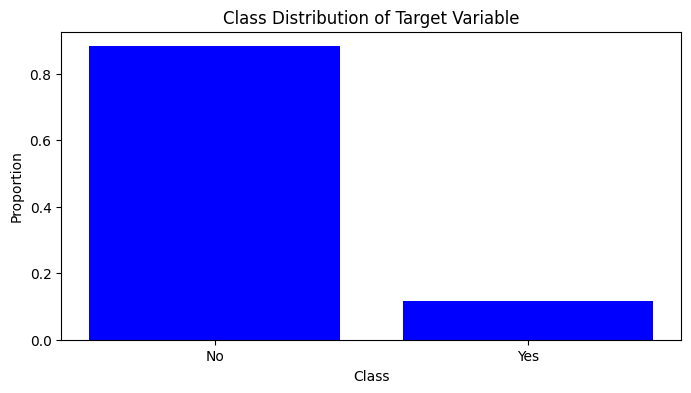

In [25]:
import matplotlib.pyplot as plt

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_distribution.index, class_distribution.values, color='blue')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Distribution of Target Variable')
plt.xticks(class_distribution.index, ['No', 'Yes'])
plt.show()

## Predictive Model

In [ ]:
import pandas as pd
import numpy as np

# Function to take input from the user
def get_user_input():
    # Prompt the user for each input field
    print("Enter customer details for term deposit prediction:")
    Sno = int(input("Sno: "))
    Customer_number = int(input("Customer Number: "))
    Insurance = input("Insurance (yes or no): ")
    balance = float(input("Account Balance: "))
    housing = input("Housing Loan Status (yes or no): ")
    loan = input("Personal Loan Status (yes or no): ")
    contact = input("Contact Type (e.g., cellular, telephone): ")
    duration = int(input("Duration of Last Contact in Seconds: "))
    campaign = int(input("Number of Contacts During this Campaign: "))
    last_contact_day = int(input("Day of Last Contact: "))
    previous = int(input("Number of Contacts Before this Campaign: "))
    poutcome = input("Outcome of the Previous Marketing Campaign (e.g., success, failure): ")
    Count_Txn = int(input("Number of Transactions: "))
    age = int(input("Age: "))
    job = input("Job (e.g., admin, blue-collar, technician): ")
    marital = input("Marital Status (e.g., married, single): ")
    education = input("Education Level (e.g., primary, secondary, tertiary): ")
    Annual_Income = float(input("Annual Income: "))
    Gender = input("Gender (e.g., male, female): ")

    # Create a dictionary for input values
    user_data = {
        'Sno': [Sno],
        'Customer_number': [Customer_number],
        'Insurance': [Insurance],
        'balance': [balance],
        'housing': [housing],
        'loan': [loan],
        'contact': [contact],
        'duration': [duration],
        'campaign': [campaign],
        'last_contact_day': [last_contact_day],
        'previous': [previous],
        'poutcome': [poutcome],
        'Count_Txn': [Count_Txn],
        'age': [age],
        'job': [job],
        'marital': [marital],
        'education': [education],
        'Annual Income': [Annual_Income],
        'Gender': [Gender]
    }
    
    # Convert to DataFrame
    user_df = pd.DataFrame(user_data)
    return user_df

# Function to preprocess user input
def preprocess_user_input(user_df):
    # Apply the same preprocessing steps: encoding and scaling
    user_preprocessed = preprocessor.transform(user_df)
    return user_preprocessed

# Function to predict using the best model
def predict_term_deposit(user_preprocessed):
    # Use the best model (XGBoost) for prediction
    prediction_prob = models["XGBoost"].predict_proba(user_preprocessed)[:, 1]
    prediction = models["XGBoost"].predict(user_preprocessed)
    return prediction, prediction_prob

# Get user input
user_df = get_user_input()

# Preprocess the user input
user_preprocessed = preprocess_user_input(user_df)

# Predict term deposit subscription
prediction, prediction_prob = predict_term_deposit(user_preprocessed)

# Display the prediction results
if prediction[0] == 1:
    print(f"The customer is likely to subscribe to a term deposit with a probability of {prediction_prob[0]:.2f}.")
else:
    print(f"The customer is unlikely to subscribe to a term deposit with a probability of {1 - prediction_prob[0]:.2f}.")
